In [1]:
import os, glob, numpy as np, pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import roc_curve, auc, roc_auc_score
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

BASE = "outputs"                
MODELS = ["BA","DA","UA"]        

def load_all():
    rows = []
    for model in MODELS:
        for z_dir in sorted(glob.glob(os.path.join(BASE, model, "z_*"))):
            z_str = os.path.basename(z_dir).split("_",1)[1]
            z_val = float(z_str.replace("+",""))
            # Load preds
            data = np.load(os.path.join(z_dir, "preds.npz"))
            y_true  = data["y_test"]
            y_score = data["y_score"]
            # ROC
            rfile = os.path.join(z_dir, "roc.npz")
            if os.path.exists(rfile):
                r = np.load(rfile)
                fpr, tpr = r["fpr"], r["tpr"]
                auc_val  = float(r["auc"][0])
            else:
                fpr, tpr, _ = roc_curve(y_true, y_score)
                auc_val = auc(fpr, tpr)
            rows.append(dict(Model=model, z=z_val, y_true=y_true, y_score=y_score,
                             fpr=fpr, tpr=tpr, AUC=auc_val))
    return rows, pd.DataFrame(rows)

rows, summary = load_all()
print(summary[["Model","z","AUC"]])

   Model    z       AUC
0     BA  0.0  0.830583
1     BA  0.1  0.828545
2     BA  0.2  0.828541
3     BA  0.3  0.828536
4     BA  0.4  0.824912
..   ...  ...       ...
58    UA -0.6  0.829476
59    UA -0.7  0.828964
60    UA -0.8  0.830026
61    UA -0.9  0.827337
62    UA -1.0  0.828658

[63 rows x 3 columns]


In [2]:
MODEL_LABELS = {
    "BA": "Nominal-trained (NT)",
    "DA": "Data-Augmented (DA)",
    "UA": "Uncertainty-Aware (UA)"
}

MODEL_COLORS = {"BA": "C0", "DA": "C1", "UA": "C2"}

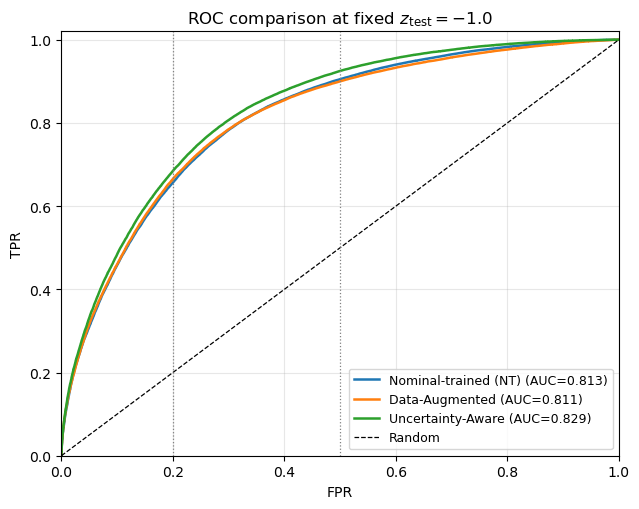

[INFO] Saved: C:\Users\ROG\anaconda_projects\8d98c197-d02b-4640-bd70-47701e1d6dcd\ROC_models_at_z-1.pdf


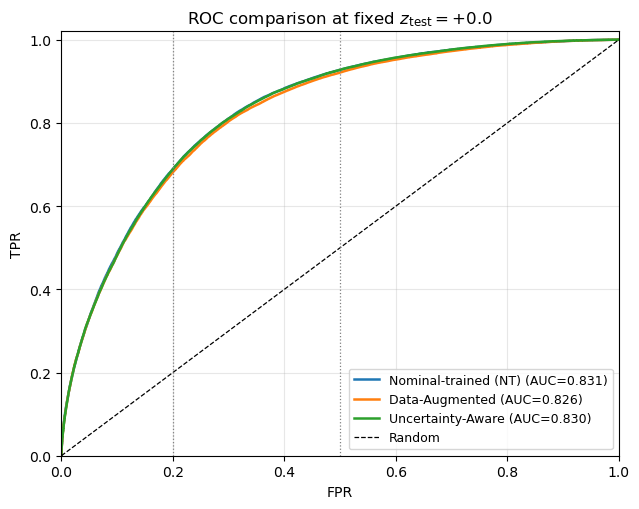

[INFO] Saved: C:\Users\ROG\anaconda_projects\8d98c197-d02b-4640-bd70-47701e1d6dcd\ROC_models_at_z0.pdf


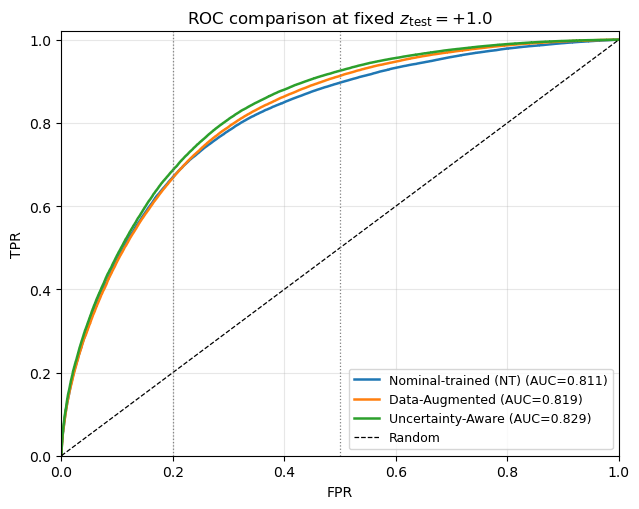

[INFO] Saved: C:\Users\ROG\anaconda_projects\8d98c197-d02b-4640-bd70-47701e1d6dcd\ROC_models_at_z+1.pdf


C:\Users\ROG\AppData\Local\Temp\ipykernel_32104\2359790918.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


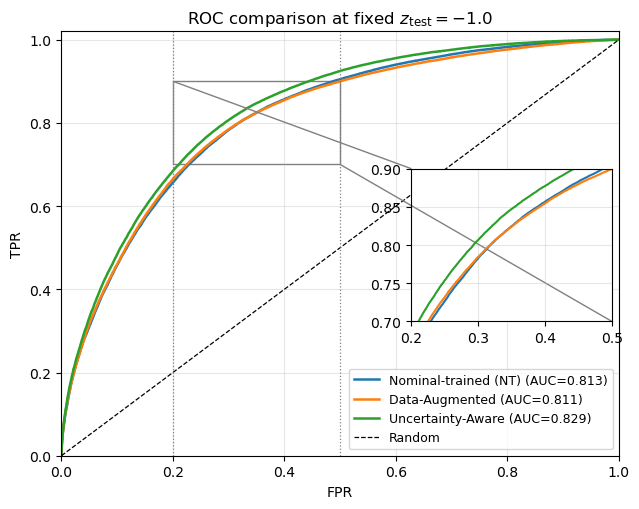

[INFO] Saved: C:\Users\ROG\anaconda_projects\8d98c197-d02b-4640-bd70-47701e1d6dcd\ROC_models_at_z-1_zoom.pdf


In [3]:
# Identify model labels
MODEL_LABELS = {
    "BA": "Nominal-trained (NT)",
    "DA": "Data-Augmented",
    "UA": "Uncertainty-Aware"
}

# Set for corresponding clours
MODEL_COLORS = {
    "BA": "C0",   # Blue
    "DA": "C1",   # Orange
    "UA": "C2"    # Green
}

# Extract curve
def find_curve(rows, model, z_target, atol=1e-9):
    z_target = float(np.round(z_target, 1))
    for r in rows:
        if r["Model"] != model:
            continue
        z_val = float(np.round(r["z"], 1))
        if np.isclose(z_val, z_target, atol=atol):
            return r["fpr"], r["tpr"], float(r.get("AUC", np.nan))
    raise ValueError(f"Did not found {model} @ z={z_target:+.1f}")

def plot_models_at_z(rows, z_target, outpath):
    """
    Compute ROC curve and AUC for a fixed z value.
    """
    plt.figure(figsize=(6.5, 5.2))
    for model in ["BA","DA","UA"]:
        fpr, tpr, auc_val = find_curve(rows, model, z_target)
        plt.plot(fpr, tpr, lw=1.8, color=MODEL_COLORS[model],
                 label=f"{MODEL_LABELS[model]} (AUC={auc_val:.3f})")
    # Plot the figure
    plt.plot([0,1],[0,1],'k--',lw=0.9, label="Random")
    plt.axvline(0.2, ls=':', lw=0.9, color='gray')
    plt.axvline(0.5, ls=':', lw=0.9, color='gray')
    plt.xlim(0,1); plt.ylim(0,1.02)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(rf"ROC comparison at fixed $z_{{\rm test}}={z_target:+.1f}$")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="lower right", fontsize=9)
    plt.tight_layout()
    plt.savefig(outpath)
    plt.show()
    print(f"[INFO] Saved: {os.path.abspath(outpath)}")

# Input three plots
plot_models_at_z(rows, z_target=-1.0, outpath="ROC_models_at_z-1.pdf")
plot_models_at_z(rows, z_target=0.0,  outpath="ROC_models_at_z0.pdf")
plot_models_at_z(rows, z_target=+1.0, outpath="ROC_models_at_z+1.pdf")

def plot_models_at_z_zoom(rows, z_target, outpath):
    """
    ROC curve comparison with partial zoom-in
    """
    fig, ax = plt.subplots(figsize=(6.5, 5.2))
    for model in ["BA","DA","UA"]:
        fpr, tpr, auc_val = find_curve(rows, model, z_target=-1)
        ax.plot(fpr, tpr, lw=1.8, color=MODEL_COLORS[model],
                label=f"{MODEL_LABELS[model]} (AUC={auc_val:.3f})")

    # Decorations
    ax.plot([0,1],[0,1],'k--',lw=0.9, label="Random")
    ax.axvline(0.2, ls=':', lw=0.9, color='gray')
    ax.axvline(0.5, ls=':', lw=0.9, color='gray')
    ax.set_xlim(0,1); ax.set_ylim(0,1.02)
    ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
    ax.set_title(rf"ROC comparison at fixed $z_{{\rm test}}= -1.0$")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="lower right", fontsize=9)

    # Partially zoom-in
    axins = inset_axes(ax, width="45%", height="45%", loc="lower right", 
                       bbox_to_anchor=(0.2,0.3,0.8,0.8), 
                       bbox_transform=ax.transAxes)
    for model in ["BA","DA","UA"]:
        fpr, tpr, _ = find_curve(rows, model, z_target=-1)
        axins.plot(fpr, tpr, lw=1.5, color=MODEL_COLORS[model])

    # Zoom in area (For example: FPR ∈ [0,0.3], TPR ∈ [0.8,1.0])
    axins.set_xlim(0.2, 0.5)
    axins.set_ylim(0.7, 0.9)
    axins.grid(True, alpha=0.3)

    # Random line
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    plt.tight_layout()
    plt.savefig(outpath)
    plt.show()
    print(f"[INFO] Saved: {os.path.abspath(outpath)}")


plot_models_at_z_zoom(rows, z_target=1.0, outpath="ROC_models_at_z-1_zoom.pdf")

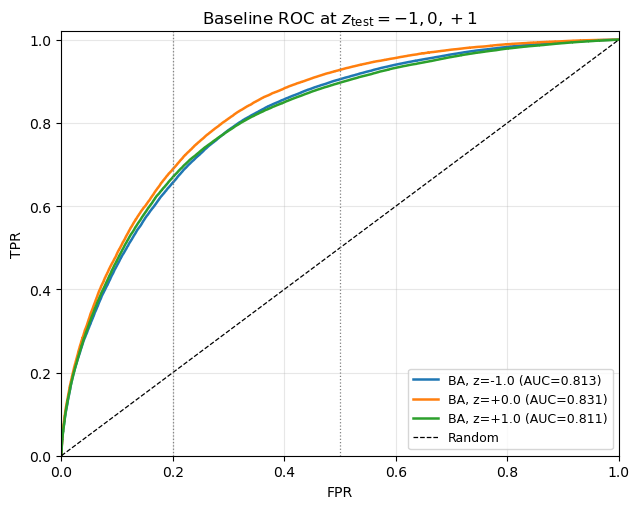

[INFO] Saved: C:\Users\ROG\anaconda_projects\8d98c197-d02b-4640-bd70-47701e1d6dcd\ROC_BA_z-1_0_+1.pdf


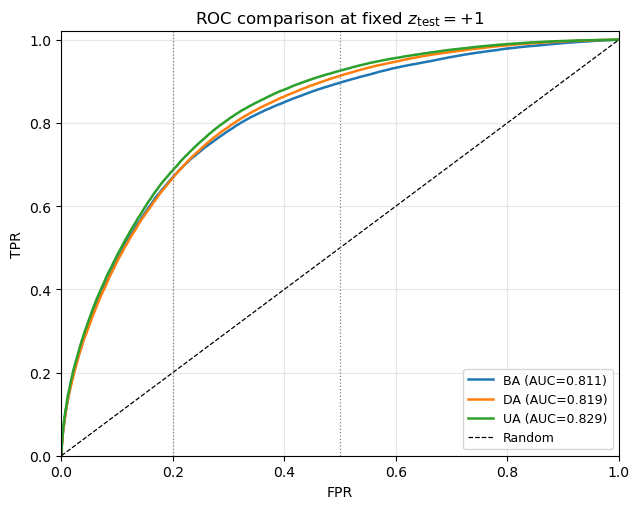

[INFO] Saved: C:\Users\ROG\anaconda_projects\8d98c197-d02b-4640-bd70-47701e1d6dcd\ROC_BA_DA_UA_at_z+1.pdf


In [4]:
def find_curve(rows, model, z_target, atol=1e-9):
    z_target = float(np.round(z_target, 1))
    for r in rows:
        if r["Model"] != model:
            continue
        z_val = float(np.round(r["z"], 1))
        if np.isclose(z_val, z_target, atol=atol):
            return r["fpr"], r["tpr"], float(r.get("AUC", np.nan))
    raise ValueError(f"Did not found {model} @ z={z_target:+.1f}")

def plot_ba_zset(rows, z_list=(-1.0, 0.0, 1.0),
                 outpath="ROC_BA_zset.pdf"):
    plt.figure(figsize=(6.5, 5.2))
    for z in z_list:
        fpr, tpr, auc_val = find_curve(rows, "BA", z)
        plt.plot(fpr, tpr, lw=1.8, label=f"BA, z={z:+.1f} (AUC={auc_val:.3f})")
    
    plt.plot([0,1],[0,1],'k--',lw=0.9, label="Random")
    plt.axvline(0.2, ls=':', lw=0.9, color='gray')
    plt.axvline(0.5, ls=':', lw=0.9, color='gray')
    plt.xlim(0,1); plt.ylim(0,1.02)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title("Baseline ROC at $z_{\\rm test}=-1,0,+1$")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="lower right", fontsize=9)
    plt.tight_layout()
    plt.savefig(outpath)
    plt.show()
    print(f"[INFO] Saved: {os.path.abspath(outpath)}")

def plot_models_at_z(rows, z_target=1.0,
                     outpath="ROC_models_at_z+1.pdf"):
    plt.figure(figsize=(6.5, 5.2))
    for model, color in zip(["BA","DA","UA"], ["C0","C1","C2"]):
        fpr, tpr, auc_val = find_curve(rows, model, z_target)
        plt.plot(fpr, tpr, lw=1.8, color=color,
                 label=f"{model} (AUC={auc_val:.3f})")
    
    plt.plot([0,1],[0,1],'k--',lw=0.9, label="Random")
    plt.axvline(0.2, ls=':', lw=0.9, color='gray')
    plt.axvline(0.5, ls=':', lw=0.9, color='gray')
    plt.xlim(0,1); plt.ylim(0,1.02)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(r"ROC comparison at fixed $z_{\rm test}=+1$")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="lower right", fontsize=9)
    plt.tight_layout()
    plt.savefig(outpath)
    plt.show()
    print(f"[INFO] Saved: {os.path.abspath(outpath)}")


plot_ba_zset(rows, z_list=(-1.0, 0.0, 1.0), outpath="ROC_BA_z-1_0_+1.pdf")
plot_models_at_z(rows, z_target=1.0, outpath="ROC_BA_DA_UA_at_z+1.pdf")

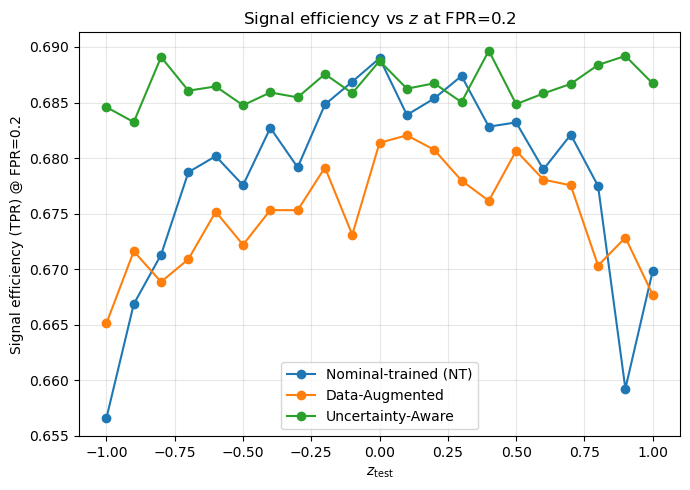

[INFO] Saved: SignalEff_vs_z_FPR0.2.pdf


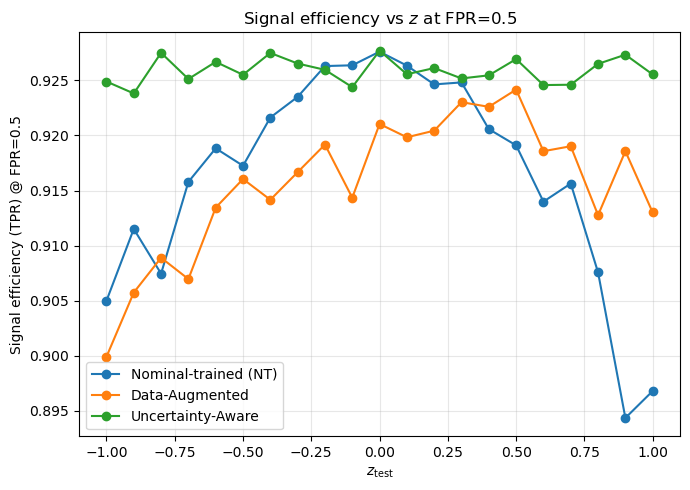

[INFO] Saved: SignalEff_vs_z_FPR0.5.pdf


In [5]:
def tpr_at_fixed_fpr(fpr, tpr, target_fpr):
    return float(np.interp(target_fpr, fpr, tpr))

target_fprs = [0.2, 0.5]
plot_data = []

# Input data
for r in rows:
    for fpr0 in target_fprs:
        tpr0 = tpr_at_fixed_fpr(r["fpr"], r["tpr"], fpr0)
        plot_data.append(dict(Model=r["Model"], z=r["z"],
                              FPR=fpr0, TPR=tpr0, AUC=r["AUC"]))

df_tpr = pd.DataFrame(plot_data)

# Plot for FPR=0.2/0.5
for fpr0 in target_fprs:
    sub = df_tpr[df_tpr["FPR"] == fpr0]
    plt.figure(figsize=(7, 5))
    for m in MODELS:  # MODELS = ["BA","DA","UA"]
        s = sub[sub["Model"] == m].sort_values("z")
        plt.plot(
            s["z"], s["TPR"], marker='o',
            color=MODEL_COLORS.get(m, None),
            label=MODEL_LABELS[m]
        )
    plt.xlabel(r"$z_{\rm test}$")
    plt.ylabel(f"Signal efficiency (TPR) @ FPR={fpr0}")
    plt.title(f"Signal efficiency vs $z$ at FPR={fpr0}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    outname = f"SignalEff_vs_z_FPR{fpr0:.1f}.pdf"   # e.g. SignalEff_vs_z_FPR0.2.pdf
    plt.savefig(outname)
    plt.show()
    print(f"[INFO] Saved: {outname}")

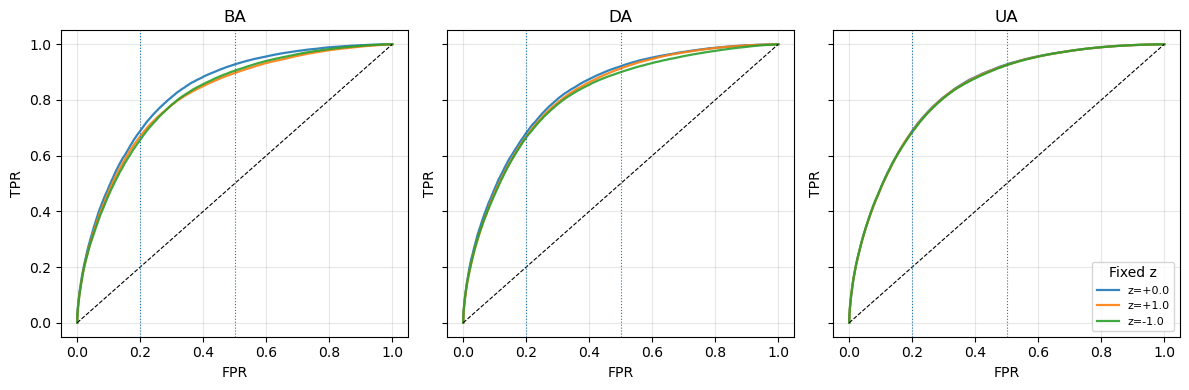

In [6]:
ZS_KEEP = np.array([-1.0, 0.0, 1.0])

def z_in_keep(z, tol=1e-9):
    return np.any(np.isclose(z, ZS_KEEP, atol=tol))

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for ax, model in zip(axes, MODELS):  # MODELS = ["BA","DA","UA"]
    for r in rows:                    # rows including {"Model","z","fpr","tpr",...}
        if r["Model"] != model: 
            continue
        if not z_in_keep(r["z"]):     
            continue
        ax.plot(r["fpr"], r["tpr"], label=f"z={r['z']:+.1f}", alpha=0.9, lw=1.6)

    ax.plot([0,1],[0,1],'k--',lw=0.8)
    ax.set_title(model); ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.grid(True, alpha=0.3)
    ax.axvline(0.2, ls=':', lw=0.8); ax.axvline(0.5, ls=':', lw=0.8)

axes[-1].legend(loc='lower right', fontsize=8, title="Fixed z")
plt.tight_layout(); plt.show()

[INFO] AUC written in: AUC_vs_z_summary.csv


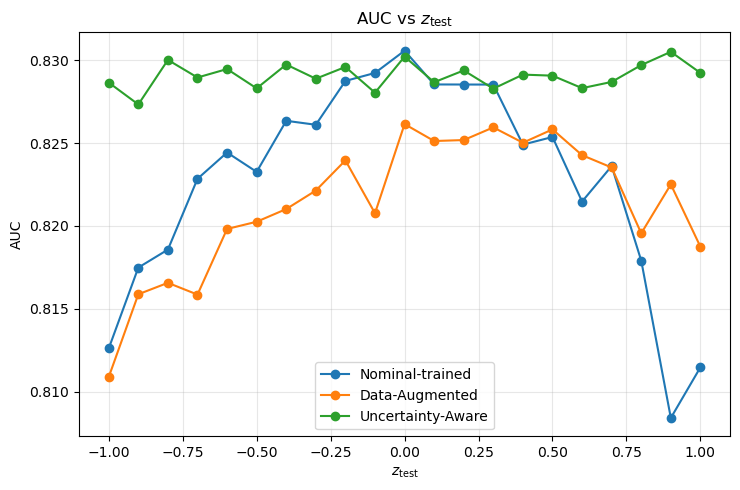

[INFO] AUC summary written in: C:\Users\ROG\anaconda_projects\8d98c197-d02b-4640-bd70-47701e1d6dcd\AUC_vs_z.pdf


In [7]:
BASE_DIR = "outputs"                 # Saved path
MODELS   = ["BA", "DA", "UA"]        # Models name
OUT_CSV  = "AUC_vs_z_summary.csv"    
OUT_PDF  = "AUC_vs_z.pdf"            

# Specify models name
MODEL_LABELS = {
    "BA": "Nominal-trained",
    "DA": "Data-Augmented",
    "UA": "Uncertainty-Aware"
}
MODEL_COLORS = {"BA": "C0", "DA": "C1", "UA": "C2"}   

def parse_z_from_dir(z_dir_name: str) -> float:
    base = os.path.basename(z_dir_name)
    z_str = base.split("_", 1)[1]  
    z_str = z_str.replace("+", "") 
    return float(z_str)

rows = []
missing = []

# Collect AUC results
for model in MODELS:
    z_dirs = sorted(glob.glob(os.path.join(BASE_DIR, model, "z_*")))
    if not z_dirs:
        print(f"Path not found: {os.path.join(BASE_DIR, model, 'z_*')}")
    for z_dir in z_dirs:
        try:
            z_val = parse_z_from_dir(z_dir)
        except Exception as e:
            print(f"Failed resolving z: {z_dir} ({e})")
            continue

        pfile = os.path.join(z_dir, "preds.npz")
        if not os.path.exists(pfile):
            missing.append(pfile)
            continue

        data = np.load(pfile)
        y_true  = data["y_test"]
        y_score = data["y_score"].ravel()

        # Calculate for AUC
        auc_val = roc_auc_score(y_true, y_score)
        rows.append(dict(Model=model, z=z_val, AUC=auc_val))

# DataFrame summarize
if not rows:
    raise RuntimeError("Did not found any AUC results, ensure outputs/<MODEL>/z_*/preds.npz generated.")

df = pd.DataFrame(rows)
df = df.sort_values(["Model", "z"]).reset_index(drop=True)

# Output CSV files
df.to_csv(OUT_CSV, index=False)
print(f"[INFO] AUC written in: {OUT_CSV}")

# Plotting
plt.figure(figsize=(7.5, 5))
for model in MODELS:
    sub = df[df["Model"] == model].sort_values("z")
    if sub.empty:
        continue
    plt.plot(
        sub["z"], sub["AUC"], marker="o",
        color=MODEL_COLORS.get(model, None),
        label=MODEL_LABELS.get(model, model)  
    )

plt.xlabel(r"$z_{\mathrm{test}}$")
plt.ylabel("AUC")
plt.title("AUC vs $z_{\\mathrm{test}}$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(OUT_PDF)
plt.show()
print(f"[INFO] AUC summary written in: {os.path.abspath(OUT_PDF)}")

# If ANY FILE MISSING
if missing:
    print("[WARN] Did not found following files")
    for p in missing:
        print("  -", p)